In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tqdm
import os
os.environ['XLA_FLAGS']="--xla_force_host_platform_device_count=4"

In [3]:
import discovery as ds
import jax
jnp = ds.matrix.jnp

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import scipy.integrate as integrate
import pandas as pd
import pickle
import json
from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic

# Load data

In [6]:
chain = pd.read_feather("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Projects/PPC15_paper/m2a_ti.feather")
ml_params = chain.iloc[chain['logprob'].argmax()].to_dict()

In [7]:
disc_dir = "/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery"
psrs = []
for psrfile in sorted(glob.glob(f'{disc_dir}/data/*-[JB]*.feather')):
    try:
        psrs.append(ds.Pulsar.read_feather(psrfile))
    except:
        continue

# Create model, `vmap` my functions

In [8]:
Tspan = ds.getspan(psrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan, common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in psrs],
                          ds.makegp_fourier_allpsr(psrs, ds.powerlaw, 14, T=Tspan,
                                                   common=['gw_log10_A', 'gw_gamma'], name='gw'))

os = gbl.os

In [9]:
os_skyscramble = gbl.os_skyscramble
# vmap across randomized sky positions
scrambled_os_vmap = jax.vmap(os_skyscramble, (0, None), 0)

# vmap now across sky positions *and* posterior samples
scrambled_os_full_vmap = jax.vmap(scrambled_os_vmap, (None, 0), 0)

# Run `vmap` across scrambles but for max likelihood parameters

In [10]:
key = ds.matrix.jnpkey(42)
nscrambles = 5_000

# create a bunch of random positions on the sky
key, subkey = ds.matrix.jnpsplit(key)
rposes = jax.random.normal(subkey, (3, 67, nscrambles))
final_positions = (rposes / jnp.linalg.norm(rposes, axis=0)).T

In [11]:
# run with same posterior draw, but 50,000 sky scrambles
%time out_ml_params_scrambles = scrambled_os_vmap(final_positions, ml_params)

CPU times: user 12.5 s, sys: 1.13 s, total: 13.7 s
Wall time: 10.8 s


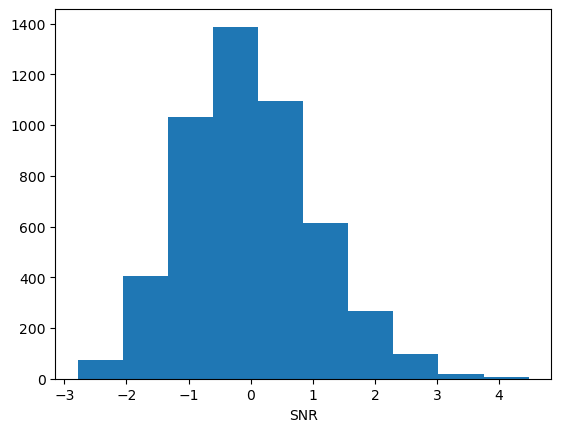

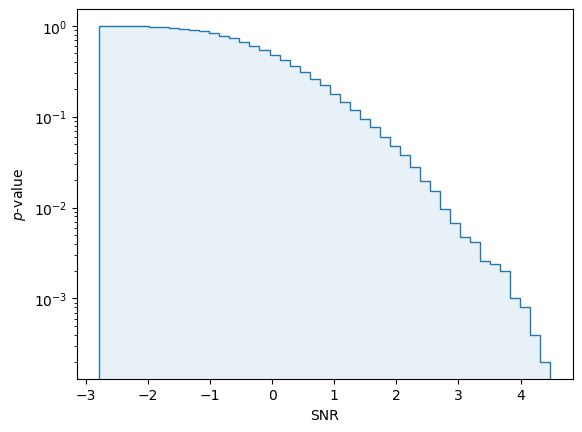

In [27]:
plt.hist(out_ml_params_scrambles['snr'])
plt.xlabel("SNR")
plt.show()

plt.hist(out_ml_params_scrambles['snr'], cumulative=-1, histtype='step', bins='auto', density=True)
plt.hist(out_ml_params_scrambles['snr'], cumulative=-1, alpha=0.1, bins='auto', color='C0', density=True)
plt.xlabel("SNR")
plt.ylabel("$p$-value")
plt.yscale("log")
plt.show()

# `vmap` across scrambles and posterior samples

In [13]:
def chain_sample(chain, nsamples):
    out = chain.sample(nsamples)
    out = {name: jnp.array(out[name].to_numpy()) for name in out.columns}
    return out

In [23]:
# get 10 posterior samples
Nsamples = 100
chainsamps = chain_sample(chain, Nsamples)

In [24]:

total_result = scrambled_os_full_vmap(final_positions, chainsamps)

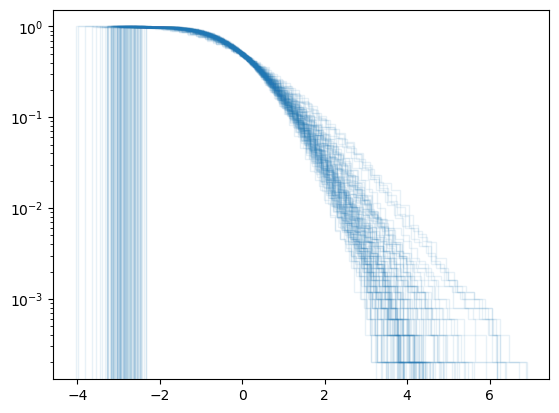

In [26]:
for ii in range(Nsamples):
    plt.hist(total_result['snr'][ii, :], cumulative=-1, histtype='step', bins='auto', density=True, alpha=0.1, color='C0')
plt.yscale("log")
plt.show()